# IMPORT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# path dataset
file_path = "/content/drive/MyDrive/Progetti data science/Progetto Python/Classificazione/songs_spotify.csv"

Mounted at /content/drive


In [ ]:
# Main libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from collections import Counter


#import optuna
from xgboost import XGBClassifier




#Processing libraries
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.compose import make_column_transformer, make_column_selector


# Model libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsClassifier


from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Testing libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV 
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report, auc, confusion_matrix, f1_score, plot_roc_curve


from sklearn import set_config

# Render modello
from sklearn.tree import plot_tree

# ETL 

In [ ]:
# import file and watching head
df = pd.read_csv(file_path, low_memory=False)

df.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,...,id,uri,track_href,analysis_url,duration_ms,time_signature,genre,song_name,Unnamed: 0,title
0,0.831,0.814,2,-7.364,1,0.4200,0.0598,0.013400,0.0556,0.3890,...,2Vc6NJ9PW9gD9q343XFRKx,spotify:track:2Vc6NJ9PW9gD9q343XFRKx,https://api.spotify.com/v1/tracks/2Vc6NJ9PW9gD...,https://api.spotify.com/v1/audio-analysis/2Vc6...,124539,4,Dark Trap,Mercury: Retrograde,NaN,NaN
1,0.719,0.493,8,-7.230,1,0.0794,0.4010,0.000000,0.1180,0.1240,...,7pgJBLVz5VmnL7uGHmRj6p,spotify:track:7pgJBLVz5VmnL7uGHmRj6p,https://api.spotify.com/v1/tracks/7pgJBLVz5Vmn...,https://api.spotify.com/v1/audio-analysis/7pgJ...,224427,4,Dark Trap,Pathology,NaN,NaN
2,0.850,0.893,5,-4.783,1,0.0623,0.0138,0.000004,0.3720,0.0391,...,0vSWgAlfpye0WCGeNmuNhy,spotify:track:0vSWgAlfpye0WCGeNmuNhy,https://api.spotify.com/v1/tracks/0vSWgAlfpye0...,https://api.spotify.com/v1/audio-analysis/0vSW...,98821,4,Dark Trap,Symbiote,NaN,NaN
3,0.476,0.781,0,-4.710,1,0.1030,0.0237,0.000000,0.1140,0.1750,...,0VSXnJqQkwuH2ei1nOQ1nu,spotify:track:0VSXnJqQkwuH2ei1nOQ1nu,https://api.spotify.com/v1/tracks/0VSXnJqQkwuH...,https://api.spotify.com/v1/audio-analysis/0VSX...,123661,3,Dark Trap,ProductOfDrugs (Prod. The Virus and Antidote),NaN,NaN
4,0.798,0.624,2,-7.668,1,0.2930,0.2170,0.000000,0.1660,0.5910,...,4jCeguq9rMTlbMmPHuO7S3,spotify:track:4jCeguq9rMTlbMmPHuO7S3,https://api.spotify.com/v1/tracks/4jCeguq9rMTl...,https://api.spotify.com/v1/audio-analysis/4jCe...,123298,4,Dark Trap,Venom,NaN,NaN


<h3> Eliminiamo i dati categorici, tranne la colonna del genere musicale <h3>

In [ ]:
df_class = df.drop(columns = ["type", "id", "uri", "track_href", "analysis_url", "song_name","Unnamed: 0", "title" ])

# ADDESTRAMENTO MODELLI

## Funzioni e parametri comuni a tutti i modelli

<h3> Seed che sarà usato in tutti gli algoritmi <h3>

In [ ]:
seed = 42

<h3> Funzione di supporto per plottare l'andamento delle prestazioni in base a 2 dei parametri utilizzati nella grid search <h3>

In [ ]:
# tree_table -> dataset contenente i valori da plottare
# name_param_1 -> nome del primo parametro 
# name_param_2 -> nome del secondo parametro 
# metrica -> nome della metrica utilizzata


def plot_grid_search_line(tree_table, nome_param_1, nome_param_2, metrica = 'accuracy'):

    # creiamo due pivot_table, uno per i dati della media ed uno per i dati della deviazione standars
    df_media = tree_table.pivot_table(values=metrica, index=nome_param_1, columns=nome_param_2)
    df_std = tree_table.pivot_table(values='Std_deviation', index=nome_param_1, columns=nome_param_2)

    # Creiamo un plot con due figure
    _, (ax1, ax2) = plt.subplots(1,2, figsize = (18, 8))
    
    # per ogni valore assunto dal parametro2 creiamo una linea 
    for valore in sorted(list(set(tree_table[nome_param_2])), reverse=True):
      ax1.plot(df_media[valore], label=f'{nome_param_2}: {valore}', linestyle = '--', marker = 'o')

    ax1.set_title(f'{metrica} media \n per iterazione', fontsize=18, fontweight='bold')
    ax1.set_xlabel(nome_param_1, fontsize=16)
    ax1.set_ylabel(f'Media della {metrica}', fontsize=16)
    ax1.legend(loc="best", fontsize=15)
    ax1.grid('on')

    # per ogni valore assunto dal parametro2 creiamo una linea 
    for valore in sorted(list(set(tree_table[nome_param_2])), reverse=True):
      ax2.plot(df_std[valore], label=f'{nome_param_2}: {valore}', linestyle = '--', marker = 'o')

    ax2.set_title(f'Varianza della {metrica} \n per iterazione', fontsize=18, fontweight='bold')
    ax2.set_xlabel(nome_param_1, fontsize=16)
    ax2.set_ylabel(f'Varianza della {metrica}', fontsize=16)
    ax2.legend(loc="best", fontsize=15)
    ax2.grid('on')


<h3> Funzione di supporto per plottare una heatmap delle prestazioni in base a 2 o 3 dei parametri utilizzati nella grid search <h3>

In [ ]:
# tree_table -> dataset contenente i valori da plottare
# name_param_1 -> nome del primo parametro 
# name_param_2 -> nome del secondo parametro 
# nome_param_3 -> nome del terzo parametro 

def plot_grid_search_heatmap(tree_table, nome_param_1, nome_param_2, nome_param_3, metrica='accuracy', size=(20, 6)):

      # estraggo il valore massimo e minimo per la media (servirà per la legenda dell'heatmap)
      min_of_mean = tree_table[metrica].min()
      max_of_mean = tree_table[metrica].max()
      #estraggo il valore massimo e minimo per la deviazione standard (servirà per la legenda dell'heatmap)
      min_of_std = tree_table['Std_deviation'].min()
      max_of_std = tree_table['Std_deviation'].max()
      # estraggo i valori categorici unici nella colonna
      unique_values = sorted(list(set(list(tree_table[nome_param_3]))))

      # creo un subploat con due colonne ed u numero di righe pari al numero di valori unici nel terzo parametro
      fig, axs = plt.subplots(len(unique_values), 2, figsize=size)
      fig.tight_layout(pad=8.0)
      axs = axs.ravel()

      # iteriamo da 0 al doppio del numero di valori unici del parametro tre, con passo pari a due 
      # (in questo modo posso riferirmi al grafico axs[i] per la media ed il grafico axs[i+1] per la varianza) 
      for i in range(0, (len(unique_values))*2, 2):
        # estraiamo i valori nel dataframe relativi all'i_esimo valore unico del parametro_3
        values_for_category = tree_table[tree_table[nome_param_3] == unique_values[int(i/2)]]



        # creo la tabella pivot per l'accuracy e la plotto come heatmap
        acc_heatmap = values_for_category.pivot_table(values=metrica, index=nome_param_1, columns=nome_param_2)
        sns.heatmap(acc_heatmap, annot=True, fmt='.4f', linewidth=.5, ax=axs[i], vmin=min_of_mean, vmax=max_of_mean, cmap = "flare")
        axs[i].set_title(f'{metrica} con {nome_param_3}: \n {unique_values[int(i/2)]}', fontsize=18, fontweight='bold')
        axs[i].set_xlabel(nome_param_2, fontsize=12, fontweight='bold')
        axs[i].set_ylabel(nome_param_1, fontsize=12, fontweight='bold')
        # scorriamo la tabella pivot dell'Accuracy per cercare la posizione del massimo valore
        max_value_acc = 0
        max_col_acc = 0
        max_index_acc = 0
        current_index_acc = 0

        for idx, row in acc_heatmap.iterrows():
          if np.max(row) > max_value_acc:
              max_value_acc = np.max(row) 
              max_col_acc = np.argmax(row)
              max_index_acc = current_index_acc
          current_index_acc += 1 
        
        # plot del rettangolo sulla posizione del massimo valore
        axs[i].add_patch(plt.Rectangle((max_col_acc, max_index_acc), 1, 1, fc='none', ec='black', lw=3, clip_on=False))



        # creo la tabella pivot per la deviazione standard e la plotto come heatmap
        std_heatmap = values_for_category.pivot_table(values='Std_deviation', index=nome_param_1, columns=nome_param_2)
        sns.heatmap(std_heatmap, annot=True, fmt='.4f', linewidth=.5, ax=axs[i+1], vmin=min_of_std, vmax=max_of_std, cmap = "crest")
        axs[i+1].set_title(f'Deviazione standard con {nome_param_3}: \n {unique_values[int(i/2)]}', fontsize=18, fontweight='bold')
        axs[i+1].set_xlabel(nome_param_2, fontsize=12, fontweight='bold')
        axs[i+1].set_ylabel(nome_param_1, fontsize=12, fontweight='bold')
        # scorriamo la tabella pivot della deviazione standard per cercare la posizione del massimo valore
        min_value_std = 100
        min_col_std = 0
        min_index_std = 0
        current_index_std = 0

        for idx, row in std_heatmap.iterrows():
          if np.min(row) < min_value_std:
              min_value_std = np.min(row) 
              min_col_std = np.argmin(row)
              min_index_std = current_index_std
          current_index_std += 1

        # plot del rettangolo sulla posizione del massimo valore
        axs[i+1].add_patch(plt.Rectangle((min_col_std, min_index_std), 1, 1, fc='none', ec='black', lw=3, clip_on=False))


<h3> Droppiamo le righe relative al genere "Pop" <h3>

In [ ]:
df_class = df_class[df_class["genre"] != "Pop"]
df_class

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,genre
0,0.831,0.814,2,-7.364,1,0.4200,0.059800,0.013400,0.0556,0.3890,156.985,124539,4,Dark Trap
1,0.719,0.493,8,-7.230,1,0.0794,0.401000,0.000000,0.1180,0.1240,115.080,224427,4,Dark Trap
2,0.850,0.893,5,-4.783,1,0.0623,0.013800,0.000004,0.3720,0.0391,218.050,98821,4,Dark Trap
3,0.476,0.781,0,-4.710,1,0.1030,0.023700,0.000000,0.1140,0.1750,186.948,123661,3,Dark Trap
4,0.798,0.624,2,-7.668,1,0.2930,0.217000,0.000000,0.1660,0.5910,147.988,123298,4,Dark Trap
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42300,0.528,0.693,4,-5.148,1,0.0304,0.031500,0.000345,0.1210,0.3940,150.013,269208,4,hardstyle
42301,0.517,0.768,0,-7.922,0,0.0479,0.022500,0.000018,0.2050,0.3830,149.928,210112,4,hardstyle
42302,0.361,0.821,8,-3.102,1,0.0505,0.026000,0.000242,0.3850,0.1240,154.935,234823,4,hardstyle
42303,0.477,0.921,6,-4.777,0,0.0392,0.000551,0.029600,0.0575,0.4880,150.042,323200,4,hardstyle


<h3> Split stratificato in train (85%) e test (15%) <h3>

In [ ]:
X = df_class.drop(['genre'], axis=1)
y = df_class['genre']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=seed, stratify=y)


print(f'X_Train: {X_train.shape}')
print(f'X_Test: {X_test.shape}')
print(f'y_Train: {y_train.shape}')
print(f'y_Test: {y_test.shape}')

X_Train: (35567, 13)
X_Test: (6277, 13)
y_Train: (35567,)
y_Test: (6277,)


<h3> Parte della pipeline che sarà uguale in tutti gli algoritmi di classificazione (cioè la parte di scaling) <h3>

In [1]:
# contiene la lista delle colonne da normalizzare (tutte tranne mode che vale o 0 o 1 quindi non ha senso normalizzarlo)
to_normalize = list(X.drop(['mode'], axis=1).columns)

# creiamo un normalizer che è una pipeline costituita solo dallo standard scaler
normalizer = make_pipeline(
    StandardScaler()
)

# creiamo una trasformazione che applica la pipeline di normalizzazione solo alla lista di colonne che ci interessano 
# il "passthrough" dice che le colonne nella lista "to_normalize" vengono normalizzate, 
# le altre invece vengono lasciate invariate (altrimenti senza "passthrough" verrebbero eliminate)
preprocessor = make_column_transformer(
    (normalizer, to_normalize),
    remainder='passthrough'
)

NameError: ignored

## Classification Tree

<h3> Creazione della pipeline e scelta dei parametri per la GridSearch <h3>

In [ ]:
tree_pipe = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['tree', DecisionTreeClassifier()]],
    verbose = True)

tree_max_depth = [i for i in range(8, 20, 2)]
tree_min_samples_split = [i for i in range(10, 65, 10)]
tree_criterion = ['entropy', 'gini']

param_grid = {
    'tree__max_depth': tree_max_depth,
    'tree__min_samples_split': tree_min_samples_split,
    'tree__random_state': [seed],
    'tree__criterion': tree_criterion
    }


set_config(display='diagram')
display(tree_pipe)
set_config(display='text')

Pipeline(steps=[['scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature'])])],
                ['tree', DecisionTreeClassifier()]],
         verbose=True)

### Valutazione parametri

<h3> Applichiamo sul dataset di train la GridSearch facendo una Cross Validation con K = 5 <h3>

In [ ]:
scoring='accuracy'

tree_model = GridSearchCV(tree_pipe,
                    param_grid=param_grid,
                    cv=3,
                    n_jobs=-1,
                    verbose=80,
                    scoring=scoring
                    )


# alleniamo il modello e valutiamo i risultati della Cross Validation eseguita dalla GridSearch 
tree_pipe_grid_results = tree_model.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .............. (step 2 of 2) Processing tree, total=   0.9s


<h3> Prime 10 iterazioni con Accuracy più alta <h3>

In [ ]:
tree_table = pd.concat([pd.DataFrame(tree_pipe_grid_results.cv_results_["params"]),
                        pd.DataFrame(tree_pipe_grid_results.cv_results_["mean_test_score"], columns=[scoring]),
                        pd.DataFrame(tree_pipe_grid_results.cv_results_["std_test_score"], columns = ['Std_deviation'])],axis=1).\
                        sort_values([scoring], ascending=False)
tree_table.head(10)

,tree__criterion,tree__max_depth,tree__min_samples_split,tree__random_state,accuracy,Std_deviation
7,entropy,10,20,42,0.631681,0.002062
8,entropy,10,30,42,0.631063,0.001477
6,entropy,10,10,42,0.630641,0.001028
9,entropy,10,40,42,0.629516,0.002519
10,entropy,10,50,42,0.628307,0.002576
11,entropy,10,60,42,0.627998,0.003150
43,gini,10,20,42,0.627323,0.001222
42,gini,10,10,42,0.627267,0.001255
44,gini,10,30,42,0.626002,0.000482
14,entropy,12,30,42,0.625299,0.002203


<h3> Andamento dell'Accuracy media e della sua deviazione standard in base a min_samples_split e max_depth <h3>

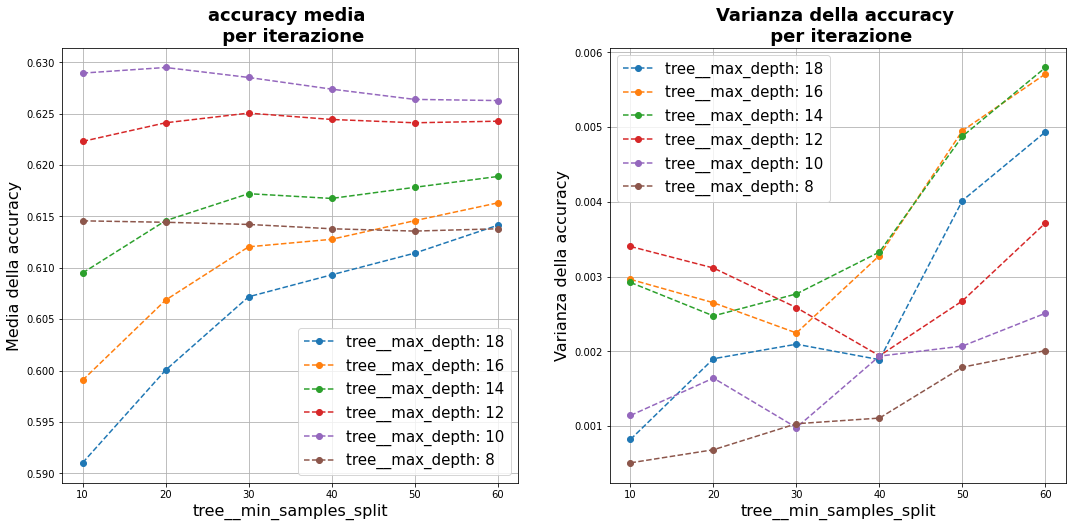

In [ ]:
plot_grid_search_line(tree_table, 'tree__min_samples_split', 'tree__max_depth')
#tree_pipe_grid_results.best_estimator_

<h3> Andamento dell'Accuracy media e della sua deviazione standard in base a min_samples_split e max_depth per ogni valore di tree_criterion <h3>

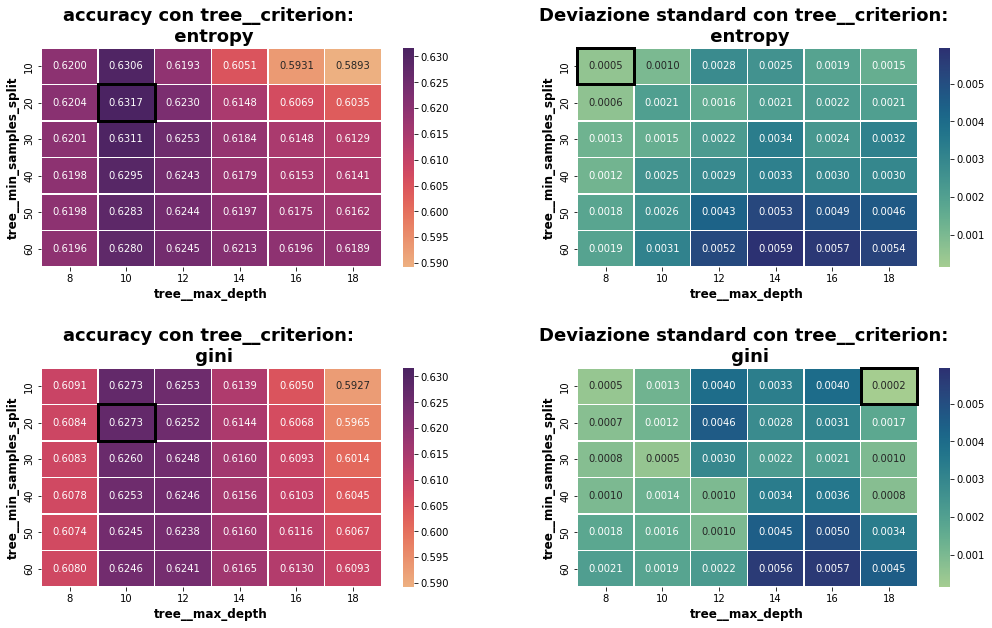

In [ ]:
plot_grid_search_heatmap(tree_table, 'tree__min_samples_split', 'tree__max_depth', 'tree__criterion', size=(16, 10), metrica=scoring)

<h3> Miglior Modello <h3>

In [ ]:
tree_pipe_grid_results.best_estimator_['tree']

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_split=20,
                       random_state=42)

### Accuratezza sul Test Set

<h3> Alleniamo un nuovo modello con i parametri ottimi e testiamolo <h3>

In [ ]:
tree_model_ottimo = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['tree', DecisionTreeClassifier(random_state=42, criterion = 'entropy', max_depth=10, min_samples_split=20)]],
    verbose = True)


tree_model_ottimo = tree_model_ottimo.fit(X_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] .............. (step 2 of 2) Processing tree, total=   0.9s


In [ ]:
classes = list(tree_model_ottimo.classes_)
features = list(X.columns)

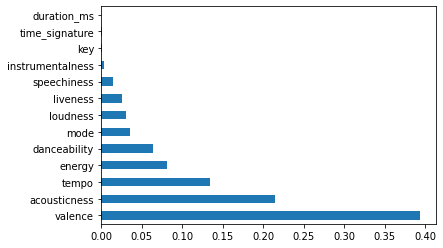

In [ ]:
feat_importances = pd.Series(tree_model_ottimo['tree'].feature_importances_, index=features)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
# calcoliamo le predizione del modello sul test_set
tree_predictions_test = tree_model_ottimo.predict(X_test)
# calcoliamo le predizione del modello sul train_set
tree_predictions_train = tree_model_ottimo.predict(X_train)


# stampiamo un resoconto della predizione
print(classification_report(tree_predictions_test, y_test))

print(f'f1_score_train: {f1_score(y_train,tree_predictions_train,average="micro")}')
print(f'f1_score_test: {f1_score(y_test,tree_predictions_test,average="micro")}')

                 precision    recall  f1-score   support

      Dark Trap       0.44      0.47      0.45       640
            Emo       0.50      0.57      0.53       221
         Hiphop       0.42      0.45      0.43       431
            Rap       0.29      0.95      0.44        84
            RnB       0.29      0.33      0.31       274
     Trap Metal       0.24      0.37      0.29       190
Underground Rap       0.61      0.43      0.50      1252
            dnb       0.97      0.95      0.96       454
      hardstyle       0.87      0.79      0.83       487
      psytrance       0.90      0.88      0.89       456
      techhouse       0.90      0.86      0.88       468
         techno       0.81      0.82      0.81       439
         trance       0.80      0.78      0.79       461
           trap       0.72      0.76      0.74       420

       accuracy                           0.64      6277
      macro avg       0.62      0.67      0.63      6277
   weighted avg       0.67   

<h3> Stampiamo la matrice di confusione in forma grafica <h3>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]), <a list of 14 Text major ticklabel objects>)

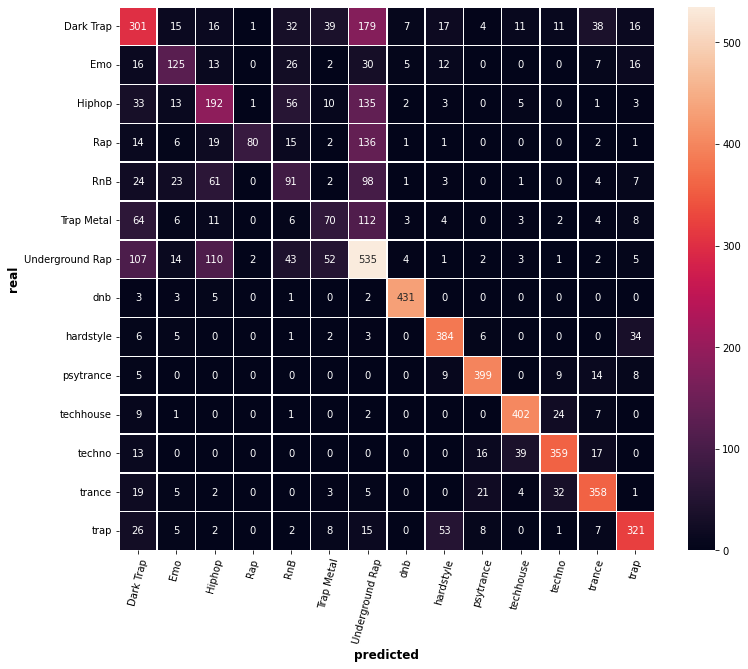

In [ ]:
tree_matrix = confusion_matrix(y_test, tree_predictions_test, labels=classes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(tree_matrix, ax=ax, annot=True, fmt='d', linewidths=0.5)
ax.set_xticklabels(classes);
ax.set_yticklabels(classes);
ax.set_xlabel('predicted', fontsize=12, fontweight='bold')
plt.xticks(rotation=75)
ax.set_ylabel('real', fontsize=12, fontweight='bold')
plt.yticks(rotation=0)

<h3> Visualizziamo il modello <h3>

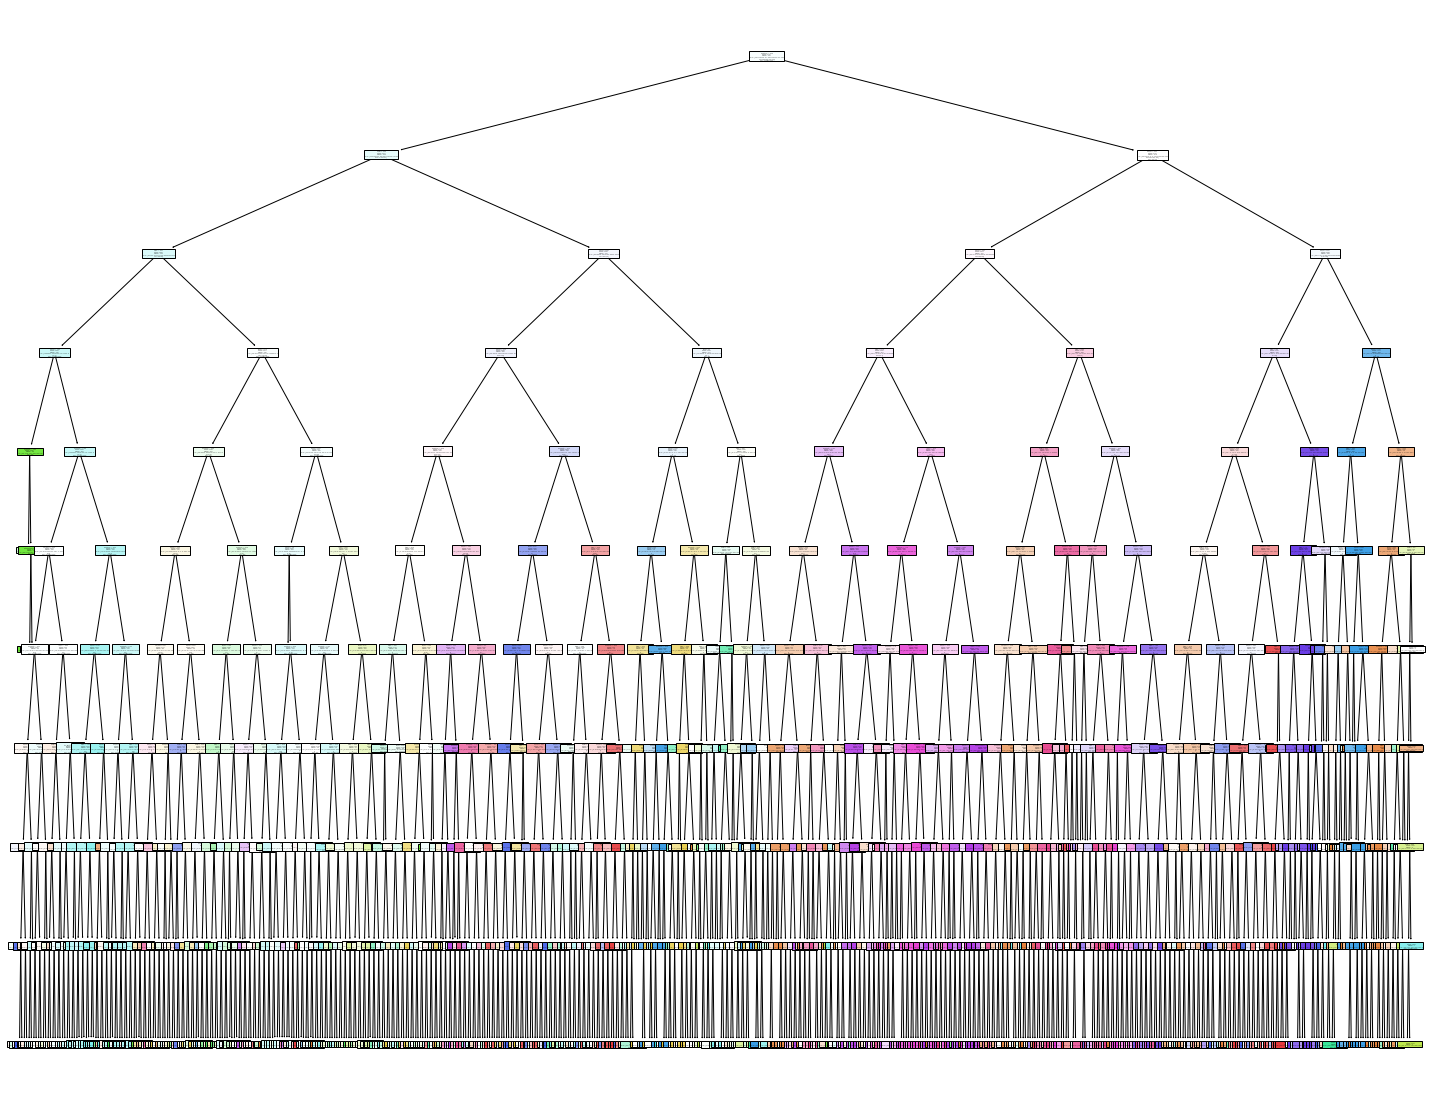

In [ ]:
"""fig = plt.figure(figsize=(25,20))
plot = plot_tree(tree_model_ottimo['tree'], 
                   feature_names=features,  
                   class_names=classes,
                   filled=True)

fig.savefig("/content/drive/MyDrive/Robe/Progetto Python/Albero_ottimo.png")
"""

## Random Forest 

<h3> Creazione della pipeline e scelta dei parametri per la GridSearch <h3>

In [ ]:
RDF_pipe = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['RDF', RandomForestClassifier()]],
    verbose = True)


RDF__max_depth = [i for i in range(12, 19, 2)]
RDF__min_samples_split = [i for i in range(10, 45, 5)]
RDF__n_estimators = [150, 250, 400]
RDF__criterion = ['entropy']


param_grid = {
    'RDF__max_depth': RDF__max_depth,
    'RDF__min_samples_split': RDF__min_samples_split,
    'RDF__random_state': [seed],
    'RDF__n_estimators': RDF__n_estimators,
    'RDF__criterion': RDF__criterion
    }


set_config(display='diagram')
display(RDF_pipe)
set_config(display='text')

Pipeline(steps=[['scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature'])])],
                ['RDF', RandomForestClassifier()]],
         verbose=True)

### Valutazione parametri

<h3> Applichiamo sul dataset di train la GridSearch facendo una Cross Validation con K = 3 <h3>

In [ ]:
scoring = 'accuracy'

RDF_model = GridSearchCV(RDF_pipe,
                    param_grid=param_grid,
                    cv=3,
                    n_jobs=-1,
                    verbose=3,
                    scoring = scoring
                    )


# alleniamo il modello e valutiamo i risultati della Cross Validation eseguita dalla GridSearch 
RDF_pipe_grid_results = RDF_model.fit(X_train, y_train)

Fitting 3 folds for each of 84 candidates, totalling 252 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing RDF, total= 1.2min


<h3> Prime 10 iterazioni con Accuracy più alta <h3>

In [ ]:
RDF_table = pd.concat([pd.DataFrame(RDF_pipe_grid_results.cv_results_["params"]),
                       pd.DataFrame(RDF_pipe_grid_results.cv_results_["mean_test_score"], columns=[scoring]), 
                       pd.DataFrame(RDF_pipe_grid_results.cv_results_["std_test_score"], columns = ['Std_deviation'])],axis=1).\
                       sort_values([scoring], ascending=False)
RDF_table.head(10)

,RDF__criterion,RDF__max_depth,RDF__min_samples_split,RDF__n_estimators,RDF__random_state,accuracy,Std_deviation
5,entropy,12,15,400,42,0.683274,0.001546
29,entropy,14,20,400,42,0.682740,0.002023
28,entropy,14,20,250,42,0.682683,0.002826
26,entropy,14,15,400,42,0.682655,0.002381
55,entropy,16,30,250,42,0.682627,0.002398
25,entropy,14,15,250,42,0.682627,0.002538
32,entropy,14,25,400,42,0.682599,0.002229
4,entropy,12,15,250,42,0.682571,0.002156
27,entropy,14,20,150,42,0.682374,0.002770
31,entropy,14,25,250,42,0.682262,0.002017


<h3> Andamento dell'Accuracy media e della sua deviazione standard in base a min_samples_split e max_depth <h3>

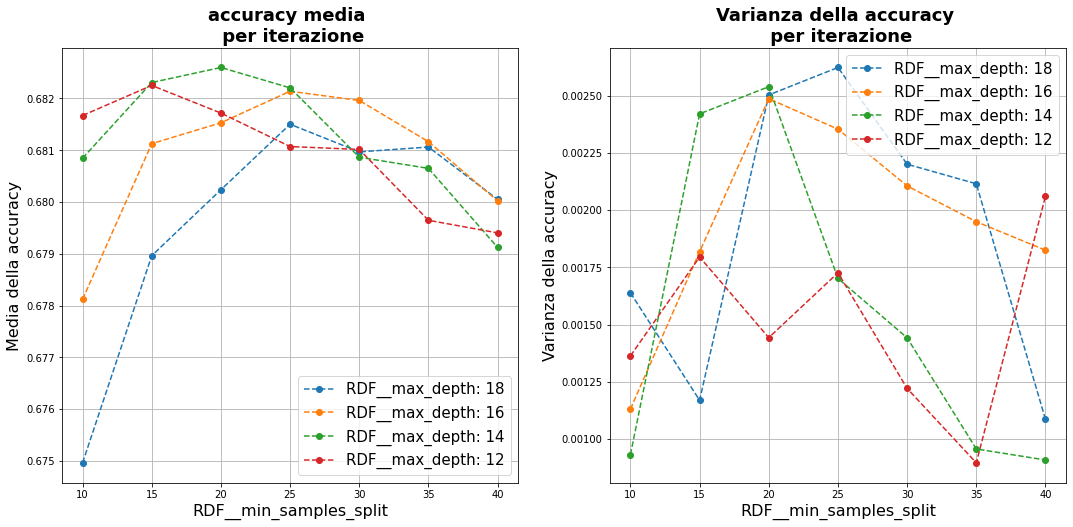

In [ ]:
plot_grid_search_line(RDF_table, 'RDF__min_samples_split', 'RDF__max_depth')
#RDF_pipe_grid_results.best_estimator_

<h3> Andamento dell'Accuracy media e della sua deviazione standard in base a min_samples_split e max_depth per ogni valore di n_estimators <h3>

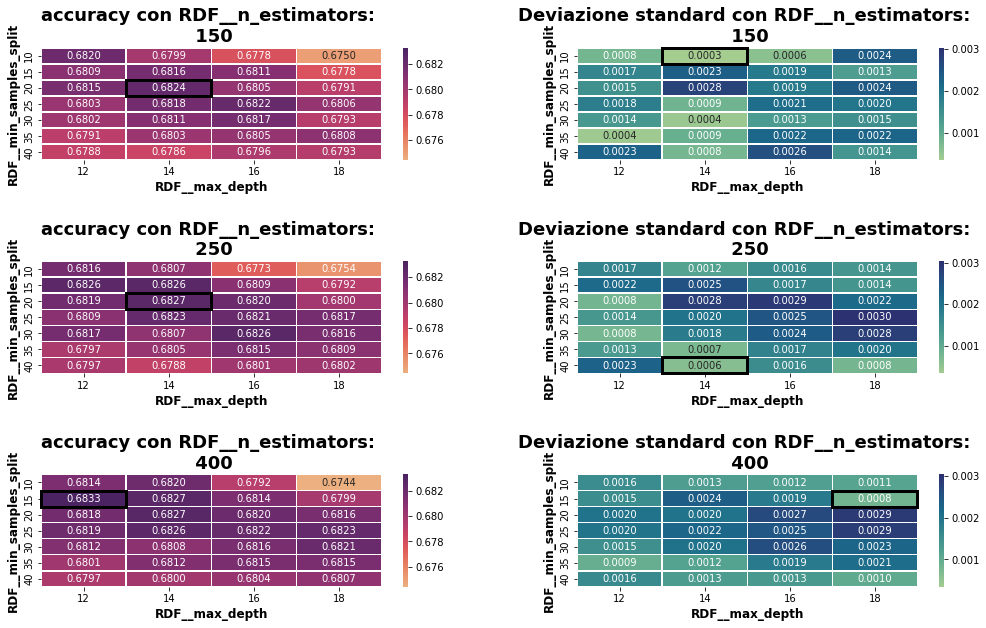

In [ ]:
plot_grid_search_heatmap(RDF_table, 'RDF__min_samples_split', 'RDF__max_depth', 'RDF__n_estimators', size=(16, 10), metrica = scoring)

<h3> Miglior Modello <h3>

In [ ]:
RDF_pipe_grid_results.best_estimator_['RDF']

RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_split=15,
                       n_estimators=400, random_state=42)

### Accuratezza sul Test Set

<h3> Alleniamo un nuovo modello con i parametri ottimi e testiamolo <h3>

In [ ]:
RDF_model_ottimo = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['RDF', RandomForestClassifier(criterion='entropy', max_depth=12, min_samples_split=20, n_estimators=250, random_state=42)]],
    verbose = True)


RDF_model_ottimo.fit(X_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing RDF, total=  43.7s


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature'])])),
                ['RDF',
                 RandomForestClassifier(criterion='entropy', max_depth=12,
     

In [ ]:
classes = list(RDF_model_ottimo.classes_)
features = list(X.columns)

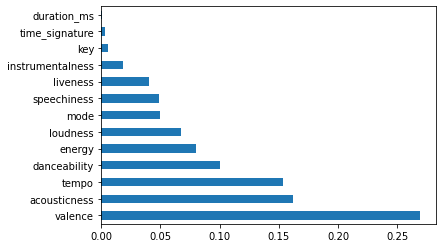

In [ ]:
feat_importances = pd.Series(RDF_model_ottimo['RDF'].feature_importances_, index=features)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
# calcoliamo le predizione del modello sul test_set
RDF_predictions_test = RDF_model_ottimo.predict(X_test)
# calcoliamo le predizione del modello sul train_set
RDF_predictions_train = RDF_model_ottimo.predict(X_train)


# stampiamo un resoconto della predizione
print(classification_report(RDF_predictions_test, y_test))
print(f'f1_score_train: {f1_score(y_train,RDF_predictions_train,average="weighted")}')
print(f'f1_score_test: {f1_score(y_test,RDF_predictions_test,average="weighted")}')

                 precision    recall  f1-score   support

      Dark Trap       0.45      0.58      0.51       536
            Emo       0.66      0.66      0.66       251
         Hiphop       0.46      0.51      0.48       406
            Rap       0.30      0.96      0.45        85
            RnB       0.31      0.46      0.37       212
     Trap Metal       0.25      0.52      0.34       143
Underground Rap       0.71      0.44      0.55      1409
            dnb       0.98      0.95      0.96       460
      hardstyle       0.93      0.82      0.87       499
      psytrance       0.93      0.90      0.91       460
      techhouse       0.93      0.88      0.90       472
         techno       0.85      0.87      0.86       436
         trance       0.85      0.80      0.83       478
           trap       0.81      0.85      0.83       430

       accuracy                           0.69      6277
      macro avg       0.67      0.73      0.68      6277
   weighted avg       0.74   

<h3> Stampiamo la matrice di confusione in forma grafica <h3>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]), <a list of 14 Text major ticklabel objects>)

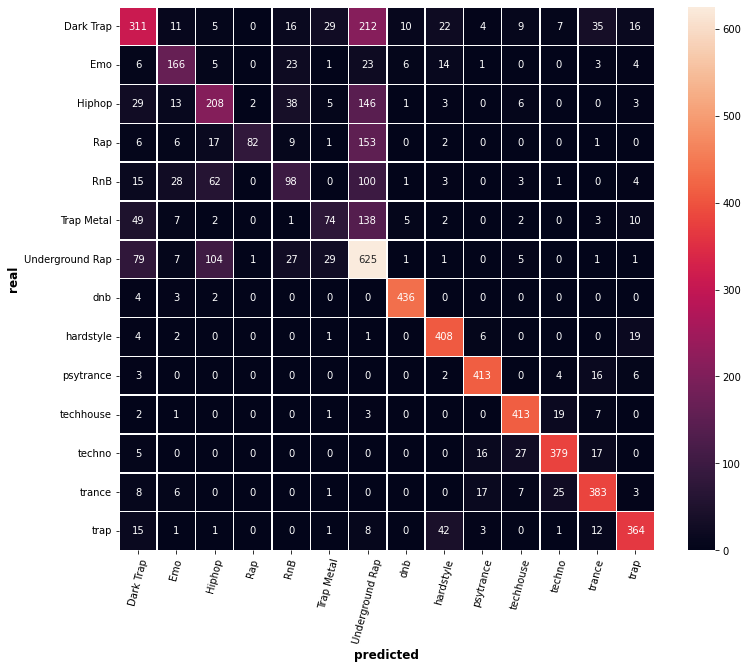

In [ ]:
DF_matrix = confusion_matrix(y_test, RDF_predictions_test, labels=classes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(DF_matrix, ax=ax, annot=True, fmt='d', linewidths=0.5)
ax.set_xticklabels(classes);
ax.set_yticklabels(classes);
ax.set_xlabel('predicted', fontsize=12, fontweight='bold')
plt.xticks(rotation=75)
ax.set_ylabel('real', fontsize=12, fontweight='bold')
plt.yticks(rotation=0)

## KNN

<h3> Creazione della pipeline e scelta dei parametri per la GridSearch <h3>

In [ ]:
knn_pipe = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['knn', KNeighborsClassifier()]],
    verbose = True)

knn_max_depth = [i for i in range(3, 28, 2)]
knn_p = [1]
knn_algorithm = ['ball_tree', 'kd_tree', 'brute']

param_grid = {
    'knn__n_neighbors': knn_max_depth,
    'knn__algorithm': knn_algorithm,
    'knn__p': knn_p
    }


set_config(display='diagram')
display(knn_pipe)
set_config(display='text')

Pipeline(steps=[['scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature'])])],
                ['knn', KNeighborsClassifier()]],
         verbose=True)

### Valutazione parametri

<h3> Applichiamo sul dataset di train la GridSearch facendo una Cross Validation con K = 5 <h3>

In [ ]:
scoring='accuracy'

knn_model = GridSearchCV(knn_pipe,
                    param_grid=param_grid,
                    cv=3,
                    n_jobs=-1,
                    verbose=80,
                    scoring=scoring
                    )


# alleniamo il modello e valutiamo i risultati della Cross Validation eseguita dalla GridSearch 
knn_pipe_grid_results = knn_model.fit(X_train, y_train)

Fitting 3 folds for each of 39 candidates, totalling 117 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing knn, total=   0.1s


<h3> Prime 10 iterazioni con Accuracy più alta <h3>

In [ ]:
knn_table = pd.concat([pd.DataFrame(knn_pipe_grid_results.cv_results_["params"]),
                        pd.DataFrame(knn_pipe_grid_results.cv_results_["mean_test_score"], columns=[scoring]),
                        pd.DataFrame(knn_pipe_grid_results.cv_results_["std_test_score"], columns = ['Std_deviation'])],axis=1).\
                        sort_values([scoring], ascending=False)
knn_table.head(10)

,knn__algorithm,knn__n_neighbors,knn__p,accuracy,Std_deviation
23,kd_tree,23,1,0.609666,0.004294
36,brute,23,1,0.609610,0.004330
10,ball_tree,23,1,0.609554,0.004007
25,kd_tree,27,1,0.609301,0.003310
9,ball_tree,21,1,0.609132,0.001967
22,kd_tree,21,1,0.609048,0.001974
11,ball_tree,25,1,0.608992,0.003551
12,ball_tree,27,1,0.608963,0.003265
24,kd_tree,25,1,0.608879,0.003627
38,brute,27,1,0.608851,0.003321


<h3> Andamento dell'Accuracy media e della sua deviazione standard in base a knn__n_neighbors e knn__algorithm <h3>

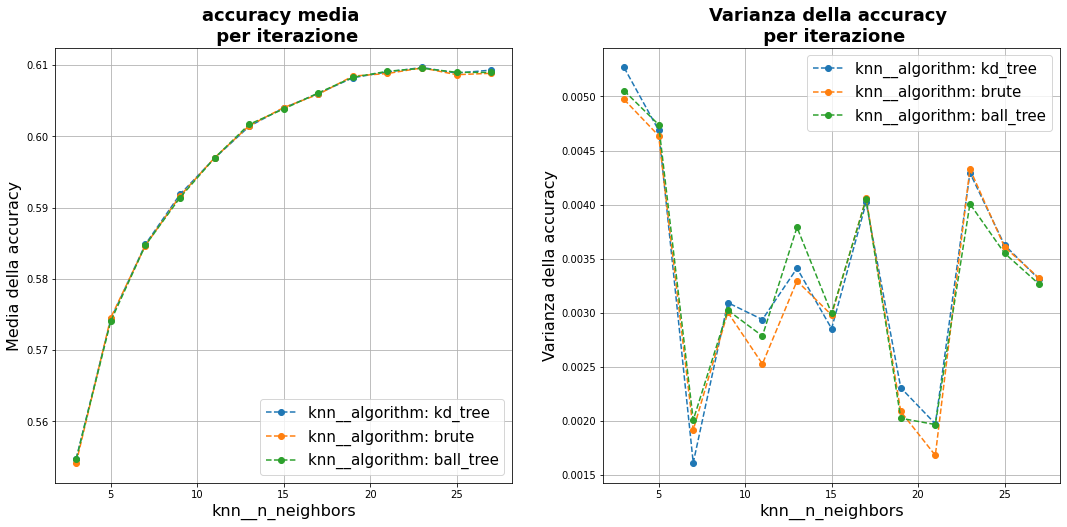

In [ ]:
plot_grid_search_line(knn_table, 'knn__n_neighbors', 'knn__algorithm')
#knn_pipe_grid_results.best_estimator_

<h3> Andamento dell'Accuracy media e della sua deviazione standard in base a knn__n_neighbors e knn__algorithm per ogni valore di knn__p <h3>

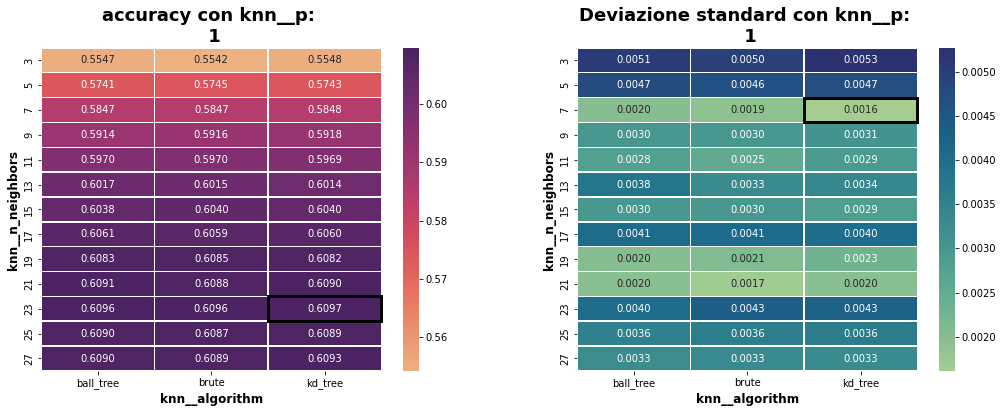

In [ ]:
plot_grid_search_heatmap(knn_table, 'knn__n_neighbors', 'knn__algorithm', 'knn__p', size=(16, 7), metrica=scoring)

<h3> Miglior Modello <h3>

In [ ]:
knn_pipe_grid_results.best_estimator_['knn']

KNeighborsClassifier(algorithm='kd_tree', n_neighbors=23, p=1)

### Accuratezza sul Test Set

<h3> Alleniamo un nuovo modello con i parametri ottimi e testiamolo <h3>

In [ ]:
knn_model_ottimo = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['knn', KNeighborsClassifier(algorithm='brute', n_neighbors=23, p=1)]],
    verbose = True)


knn_model_ottimo = knn_model_ottimo.fit(X_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ............... (step 2 of 2) Processing knn, total=   0.0s


In [ ]:
classes = list(tree_model_ottimo.classes_)
features = list(X.columns)

In [ ]:
# calcoliamo le predizione del modello sul test_set
knn_predictions_test = knn_model_ottimo.predict(X_test)
# calcoliamo le predizione del modello sul train_set
knn_predictions_train = knn_model_ottimo.predict(X_train)


# stampiamo un resoconto della predizione
print(classification_report(knn_predictions_test, y_test))

print(f'f1_score_train: {f1_score(y_train,knn_predictions_train,average="micro")}')
print(f'f1_score_test: {f1_score(y_test,knn_predictions_test,average="micro")}')

                 precision    recall  f1-score   support

      Dark Trap       0.39      0.52      0.44       518
            Emo       0.57      0.55      0.56       259
         Hiphop       0.40      0.49      0.44       368
            Rap       0.26      0.59      0.36       124
            RnB       0.26      0.40      0.31       202
     Trap Metal       0.18      0.50      0.27       105
Underground Rap       0.66      0.44      0.53      1322
            dnb       0.93      0.89      0.91       468
      hardstyle       0.85      0.63      0.72       599
      psytrance       0.87      0.76      0.81       505
      techhouse       0.87      0.78      0.82       495
         techno       0.81      0.78      0.79       462
         trance       0.68      0.71      0.70       436
           trap       0.69      0.75      0.72       414

       accuracy                           0.62      6277
      macro avg       0.60      0.63      0.60      6277
   weighted avg       0.68   

<h3> Stampiamo la matrice di confusione in forma grafica <h3>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]), <a list of 14 Text major ticklabel objects>)

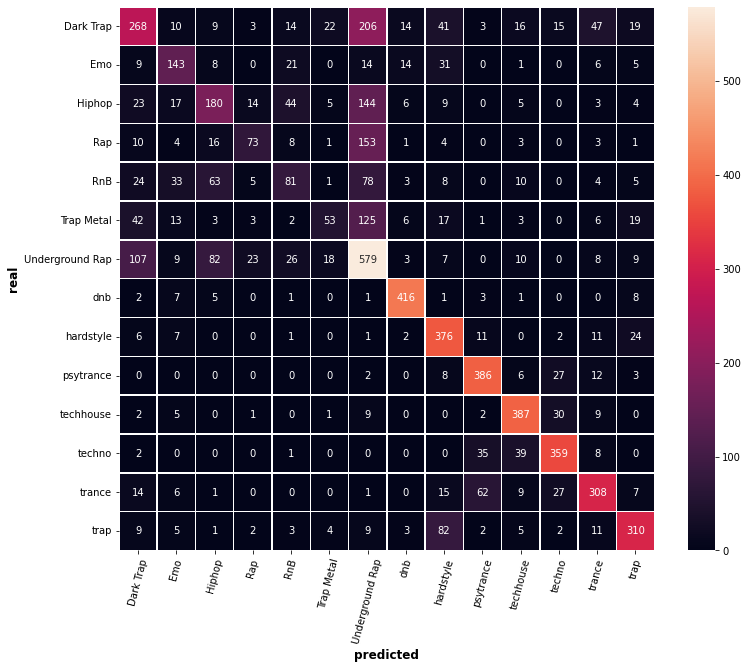

In [ ]:
knn_matrix = confusion_matrix(y_test, knn_predictions_test, labels=classes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(knn_matrix, ax=ax, annot=True, fmt='d', linewidths=0.5)
ax.set_xticklabels(classes);
ax.set_yticklabels(classes);
ax.set_xlabel('predicted', fontsize=12, fontweight='bold')
plt.xticks(rotation=75)
ax.set_ylabel('real', fontsize=12, fontweight='bold')
plt.yticks(rotation=0)

## Extra Trees 

<h3> Creazione della pipeline e scelta dei parametri per la GridSearch <h3>

In [ ]:
XT_pipe = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['XT', ExtraTreesClassifier()]
    ],
    verbose = True)


XT__max_depth = [i for i in range(10, 71, 15)]
XT__min_samples_split = [i for i in range(10, 71, 15)]
XT__n_estimators = [10, 200, 600, 1000]
XT__min_impurity_decrease = [1.0e-09]#[1.0e-12, 1.0e-09, 1.0e-03, 1.0e-01]
XT__criterion = ['entropy']


param_grid = {
    'XT__max_depth': XT__max_depth,
    'XT__min_samples_split': XT__min_samples_split,
    'XT__random_state': [seed],
    'XT__n_estimators': XT__n_estimators,
    'XT__criterion': XT__criterion,
    'XT__min_impurity_decrease': XT__min_impurity_decrease
    }


set_config(display='diagram')
display(XT_pipe)
set_config(display='text')

Pipeline(steps=[['scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature'])])],
                ['XT', ExtraTreesClassifier()]],
         verbose=True)

### Valutazione parametri

<h3> Applichiamo sul dataset di train la GridSearch facendo una Cross Validation con K = 3 <h3>

In [ ]:
scoring = 'accuracy'

XT_model = GridSearchCV(XT_pipe,
                    param_grid=param_grid,
                    cv=3, 
                    n_jobs=-1,
                    verbose=3,
                    scoring = scoring,
                    return_train_score=True
                    )

# alleniamo il modello e valutiamo i risultati della Cross Validation eseguita dalla GridSearch 
XT_pipe_grid_results = XT_model.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.8/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.0s
[Pipeline] ................ (step 2 of 2) Processing XT, total=  18.1s


<h3> Prime 10 iterazioni con Accuracy più alta <h3>

In [ ]:
XT_table = pd.concat([pd.DataFrame(XT_pipe_grid_results.cv_results_["params"]),
                       pd.DataFrame(XT_pipe_grid_results.cv_results_["mean_test_score"], columns=[scoring]), 
                       pd.DataFrame(XT_pipe_grid_results.cv_results_["std_test_score"], columns = ['Std_deviation']),
                       pd.DataFrame(XT_pipe_grid_results.cv_results_["mean_train_score"], columns=[scoring+"_train"]), 
                       pd.DataFrame(XT_pipe_grid_results.cv_results_["std_train_score"], columns = ['Std_deviation_train'])], axis=1).\
                       sort_values([scoring], ascending=False)
XT_table.head(10)

,XT__criterion,XT__max_depth,XT__min_impurity_decrease,XT__min_samples_split,XT__n_estimators,XT__random_state,accuracy,Std_deviation,accuracy_train,Std_deviation_train
46,entropy,40,1.000000e-09,25,600,42,0.664211,0.000769,0.800405,0.000555
66,entropy,55,1.000000e-09,25,600,42,0.664211,0.000769,0.800405,0.000555
86,entropy,70,1.000000e-09,25,600,42,0.664211,0.000769,0.800405,0.000555
45,entropy,40,1.000000e-09,25,200,42,0.664043,0.001575,0.799997,0.000468
65,entropy,55,1.000000e-09,25,200,42,0.664043,0.001575,0.799997,0.000468
85,entropy,70,1.000000e-09,25,200,42,0.664043,0.001575,0.799997,0.000468
47,entropy,40,1.000000e-09,25,1000,42,0.664043,0.000714,0.800306,0.000394
67,entropy,55,1.000000e-09,25,1000,42,0.664043,0.000714,0.800306,0.000394
87,entropy,70,1.000000e-09,25,1000,42,0.664043,0.000714,0.800306,0.000394
26,entropy,25,1.000000e-09,25,600,42,0.663790,0.001297,0.799154,0.001481


<h3> Andamento dell'Accuracy media e della sua deviazione standard in base a min_samples_split e max_depth <h3>

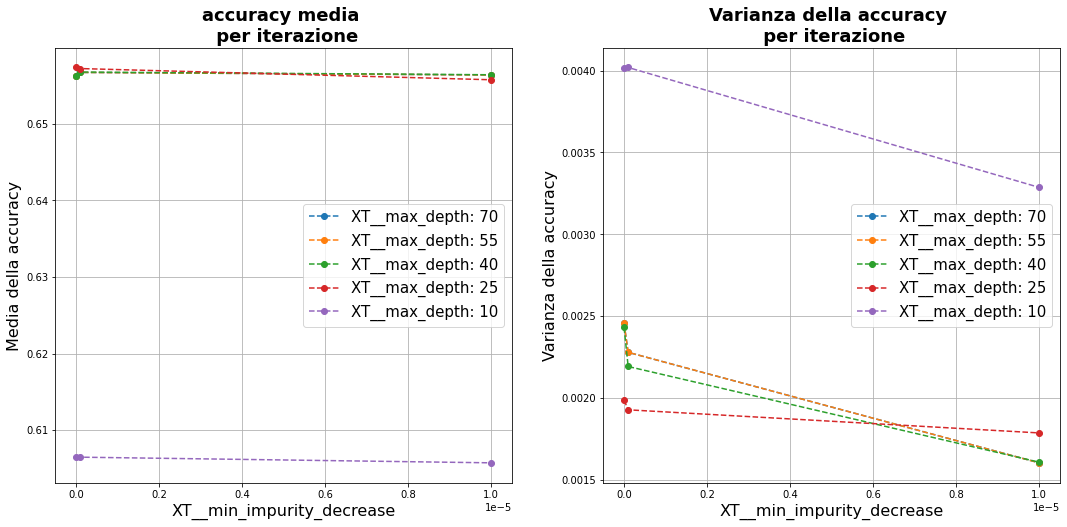

In [ ]:
plot_grid_search_line(XT_table, 'XT__min_impurity_decrease', 'XT__max_depth')


<h3> Andamento dell'Accuracy media e della sua deviazione standard in base a min_samples_split e max_depth per ogni valore di n_estimators <h3>

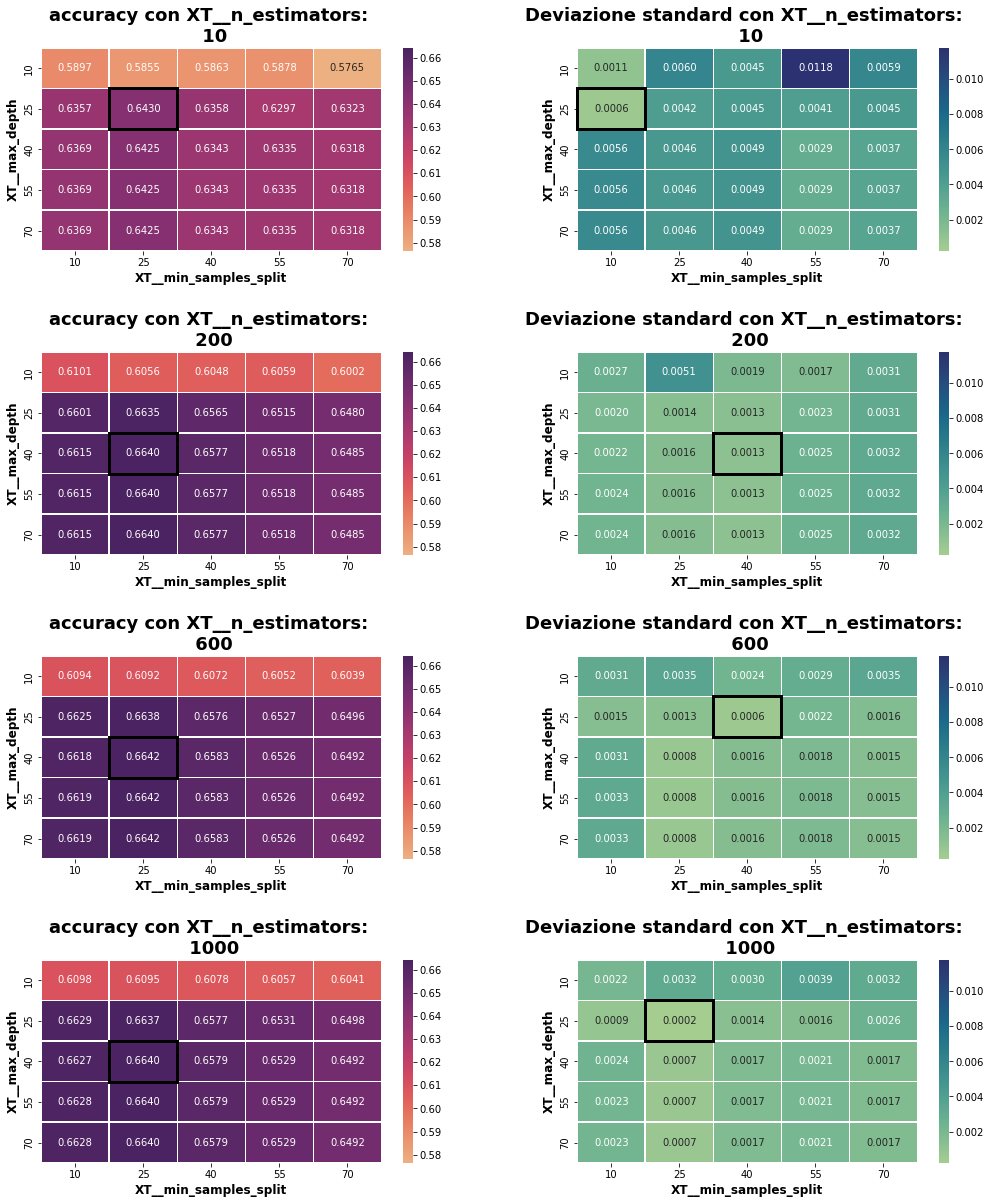

In [ ]:
plot_grid_search_heatmap(XT_table, 'XT__max_depth', 'XT__min_samples_split', 'XT__n_estimators', size=(16, 18), metrica = scoring)

<h3> Miglior Modello <h3>

In [ ]:
XT_pipe_grid_results.best_estimator_['XT']

ExtraTreesClassifier(criterion='entropy', max_depth=40,
                     min_impurity_decrease=1e-09, min_samples_split=25,
                     n_estimators=600, random_state=42)

### Accuratezza sul Test Set

<h3> Alleniamo un nuovo modello con i parametri ottimi e testiamolo <h3>

In [ ]:
XT_model_ottimo = Pipeline(steps = [
    ["scaler" , preprocessor],
    ['XT', ExtraTreesClassifier(criterion='entropy', max_depth=40,
                     min_impurity_decrease=1e-09, min_samples_split=25,
                     n_estimators=600, random_state=42)]
    ],
    verbose = True)

XT_model_ottimo.fit(X_train, y_train)

[Pipeline] ............ (step 1 of 2) Processing scaler, total=   0.1s
[Pipeline] ................ (step 2 of 2) Processing XT, total=  16.9s


Pipeline(steps=[('scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('pipeline',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['danceability', 'energy',
                                                   'key', 'loudness',
                                                   'speechiness',
                                                   'acousticness',
                                                   'instrumentalness',
                                                   'liveness', 'valence',
                                                   'tempo', 'duration_ms',
                                                   'time_signature'])])),
                ['XT',
                 ExtraTreesClassifier(criterion='entropy', max_depth=40,
        

<h3> Stampiamo l'importanza delle feature <h3>

In [ ]:
classes = list(XT_model_ottimo.classes_)
features = list(X.columns)

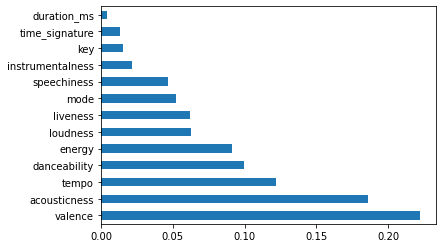

In [ ]:
feat_importances = pd.Series(XT_model_ottimo['XT'].feature_importances_, index=features)
feat_importances.nlargest(20).plot(kind='barh')

In [ ]:
# calcoliamo le predizione del modello sul test_set
XT_predictions_test = XT_model_ottimo.predict(X_test)
# calcoliamo le predizione del modello sul train_set
XT_predictions_train = XT_model_ottimo.predict(X_train)


# stampiamo un resoconto della predizione
print(classification_report(XT_predictions_test, y_test))
print(f'f1_score_train: {f1_score(y_train,XT_predictions_train,average="weighted")}')
print(f'f1_score_test: {f1_score(y_test,XT_predictions_test,average="weighted")}')

                 precision    recall  f1-score   support

      Dark Trap       0.45      0.58      0.51       535
            Emo       0.65      0.68      0.67       240
         Hiphop       0.39      0.50      0.44       356
            Rap       0.30      0.85      0.44        98
            RnB       0.28      0.52      0.36       169
     Trap Metal       0.21      0.54      0.30       114
Underground Rap       0.74      0.43      0.54      1529
            dnb       0.97      0.93      0.95       464
      hardstyle       0.89      0.81      0.85       486
      psytrance       0.93      0.86      0.89       477
      techhouse       0.90      0.85      0.87       471
         techno       0.85      0.85      0.85       441
         trance       0.80      0.77      0.79       462
           trap       0.81      0.83      0.82       435

       accuracy                           0.68      6277
      macro avg       0.65      0.72      0.66      6277
   weighted avg       0.74   

<h3> Stampiamo la matrice di confusione in forma grafica <h3>

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]), <a list of 14 Text major ticklabel objects>)

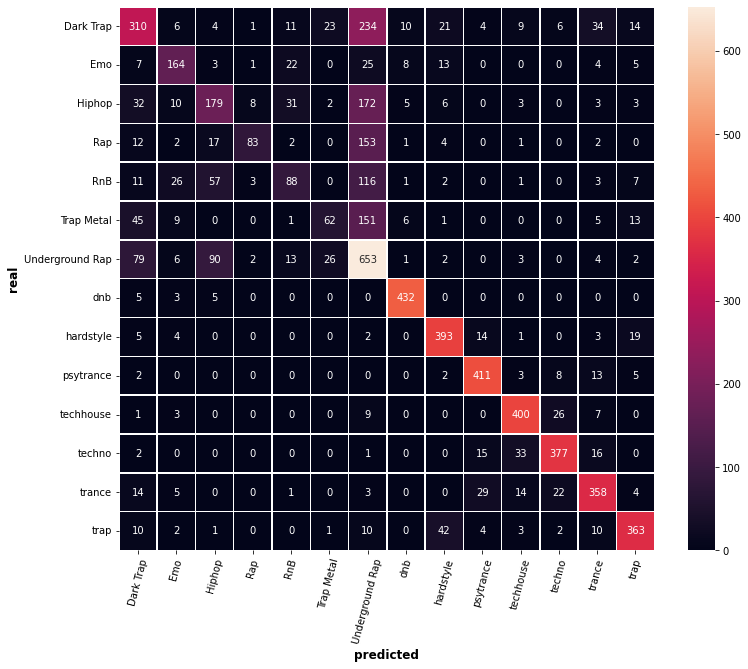

In [ ]:
XT_matrix = confusion_matrix(y_test, XT_predictions_test, labels=classes)
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(XT_matrix, ax=ax, annot=True, fmt='d', linewidths=0.5)
ax.set_xticklabels(classes);
ax.set_yticklabels(classes);
ax.set_xlabel('predicted', fontsize=12, fontweight='bold')
plt.xticks(rotation=75)
ax.set_ylabel('real', fontsize=12, fontweight='bold')
plt.yticks(rotation=0)

# CONFRONTO RISULTATI

In [ ]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Modello', 'F1 Train', 'F1 Test']
table.add_row(['Random Forest', round(f1_score(y_train,RDF_predictions_train,average="micro"), 3), round(f1_score(y_test,RDF_predictions_test,average="micro"), 3)])
table.add_row(['ExtraTree', round(f1_score(y_train,XT_predictions_train,average="micro"), 3), round(f1_score(y_test,XT_predictions_test,average="micro"), 3)])
table.add_row(['Classification Tree', round(f1_score(y_train,tree_predictions_train,average="micro"), 3), round(f1_score(y_test,tree_predictions_test,average="micro"), 3)])
table.add_row(['KNN', round(f1_score(y_train,knn_predictions_train,average="micro"), 3), round(f1_score(y_test,knn_predictions_test,average="micro"), 3)])
print(table)

+---------------------+----------+---------+
|       Modello       | F1 Train | F1 Test |
+---------------------+----------+---------+
|    Random Forest    |  0.769   |  0.695  |
|      ExtraTree      |  0.798   |  0.681  |
| Classification Tree |  0.689   |  0.645  |
|         KNN         |  0.648   |  0.624  |
+---------------------+----------+---------+
